<center><h1>Introduction to incoherent dedispersion</h1></center>

Radio signals traveling through space interact with free electrons in the interstellar medium. This leads to a variety of phenomena, one of which is <em>dispersion</em>. The signal is delayed an amount
$$\Delta t=\mathcal{D}\frac{\mathrm{DM}}{f^2}$$
where $\mathcal{D}$ is the <em>dispersion constant</em>, $f$ is the frequency, and $\mathrm{DM}$ is the <em>dispersion measure</em>, defined as the line integral of the free electron number density along the line of sight:
$$\mathrm{DM}\equiv\int n_e\;\mathrm{d}s$$
One way of thinking about the DM is as a measure of how much "stuff" there is between the source and the observer. The delay ends up being
$$\Delta t\simeq4.15\times10^3\left(\frac{f}{\mathrm{MHz}}\right)^{-2}\left(\frac{\mathrm{DM}}{\mathrm{pc\;cm}^{-3}}\right)\;\mathrm{s}$$

This leads to some interesting things. Many sources of interest, like pulses from pulsars and fast radio bursts, are broadband emitters, and we recieve their signals across a range of frequencies. Since dispersion is frequency-dependent, the signal is delayed by a different amount an each frequency, and so it becomes smeared out. To study or even detect pulsars, we need to dedisperse the signal -- i.e. subtract out this delay.

Particularly in cases where we don't know the dispersion measure ahead of time, we usually use a technique called <em>incoherent dedispersion</em>, where we dedisperse our data at a bunch of different trial DMs and then search each dedispersed data set for a signal. (You can compare this to coherent dedispersion, which does a much better job and totally removes the effects of dispersion in the ISM but requires knowledge of the DM *a priori*, or semicoherent dedispersion, a mixture of the two.)

To start, let's create a sample pulsar signal: a simple narrow, Gaussian pulse. We'll use the Crab pulsar (spin period P = 33.39 ms, dispersion measure DM = 56.77 pc cm<sup>-3</sup>).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.special as special

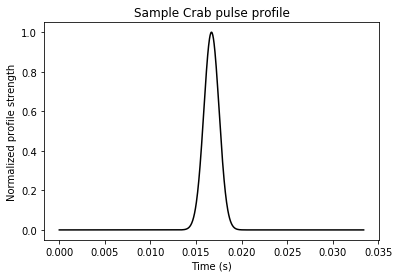

In [2]:
crab_period = 0.03339 # Crab spin period (s)
crab_DM = 56.77       # Crab DM (pc cm^-3)

def true_profile(t, amp=1, center=crab_period/2, width=crab_period/40):
    """Gaussian profile centered at a rotation phase of 0.5"""
    return amp*np.exp(-((t % crab_period) - center)**2/(2*width**2))

profile_time_arr = np.linspace(0, crab_period, 1000)

plt.plot(profile_time_arr, true_profile(profile_time_arr), 'k')
plt.xlabel('Time (s)')
plt.ylabel('Normalized profile strength')
plt.title('Sample Crab pulse profile')
plt.show()

Say we have a telescope observing the Crab at L-band, centered at a frequency $f=1420$ MHz with a bandwidth of $\Delta f=100$ MHz. Here's what the signal would look like across that frequency range over five rotation periods, assuming no noise, as well as no dispersion or other complicating effects:

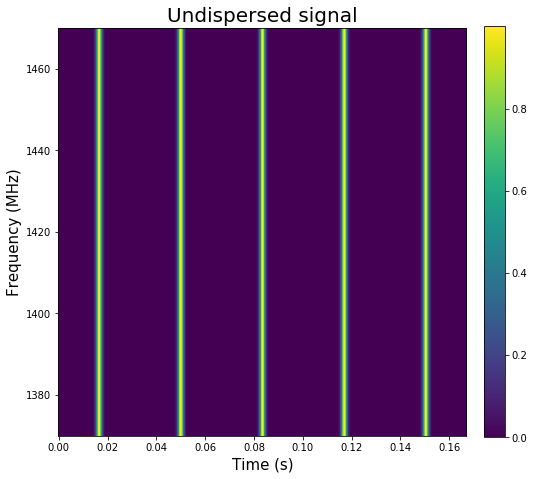

In [3]:
center_freq = 1420
bandwidth = 100
obs_length = 5*crab_period

f_low = center_freq - bandwidth/2
f_high = center_freq + bandwidth/2

def profile(t, f):
    """Undispersed Gaussian profile"""
    return true_profile(t)

t_arr = np.linspace(0, obs_length, 1024)
f_arr = np.linspace(f_low, f_high, 1024)
T, F = np.meshgrid(t_arr, f_arr)
P_undisp = profile(T, F)

# need to scale axes to get correct labels
dt = obs_length/1024
df = bandwidth/1024
extent = [t_arr[0] - dt, t_arr[-1] + dt, f_arr[0] - df, f_arr[-1] + df]

fig, ax = plt.subplots(figsize=(8, 8))

disp = ax.imshow(P_undisp, extent=extent)
ax.set_aspect(obs_length/bandwidth)

fig.colorbar(disp, fraction=0.046, pad=0.04)

disp.figure.axes[0].tick_params(axis="both", labelsize=10)

plt.xlabel('Time (s)', size=15)
plt.ylabel('Frequency (MHz)', size=15)
plt.title('Undispersed signal', size=20)
plt.show()

Now we add in our dispersion delay:

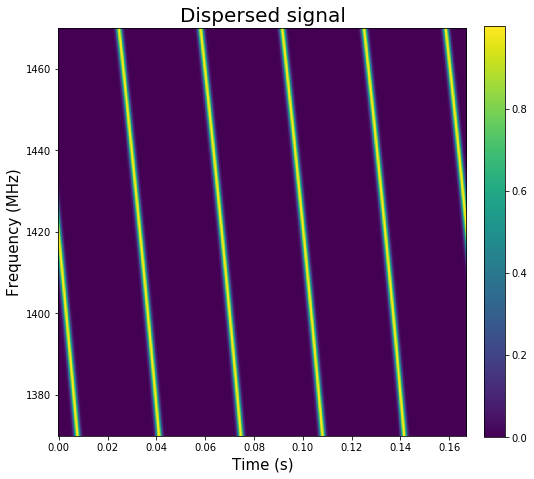

In [4]:
def delay(f, DM=crab_DM):
    """Dispersion delay in s for a given frequency in MHz and DM in pc cm^-3"""
    return 4.15*10**(3) * (f)**(-2) * DM

def dispersed_profile(t, f):
    """Dispersed Gaussian profile"""
    return profile(t + delay(f), f)

t_arr = np.linspace(0, obs_length, 1024)
f_arr = np.linspace(f_low, f_high, 1024)
T, F = np.meshgrid(t_arr, f_arr)
P_disp = dispersed_profile(T, F)

# need to scale axes to get correct labels
dt = obs_length/1024
df = bandwidth/1024
extent = [t_arr[0] - dt, t_arr[-1] + dt, f_arr[0] - df, f_arr[-1] + df]

fig, ax = plt.subplots(figsize=(8, 8))

disp = ax.imshow(P_disp, extent=extent)
ax.set_aspect(obs_length/bandwidth)

fig.colorbar(disp, fraction=0.046, pad=0.04)

disp.figure.axes[0].tick_params(axis="both", labelsize=10)

plt.xlabel('Time (s)', size=15)
plt.ylabel('Frequency (MHz)', size=15)
plt.title('Dispersed signal', size=20)
plt.show()

When we average these signals out across the frequency band, they look very different! It happens that for the Crab and our simulated observing setup, the dispersive delay between the highest and lowest frequencies is about half of the Crab's rotational period.

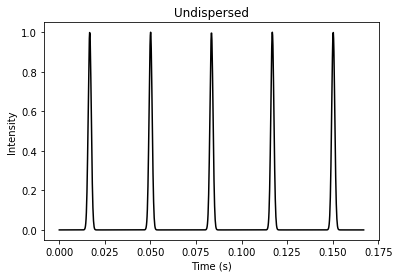

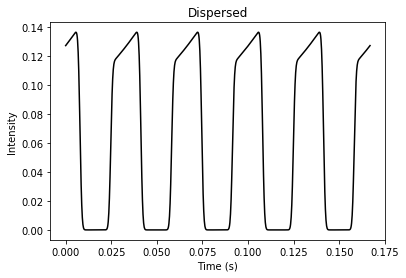

In [5]:
plt.plot(np.linspace(0, obs_length, 1024), sum(P_undisp)/1024, 'k')
plt.xlabel('Time (s)')
plt.ylabel('Intensity')
plt.title('Undispersed')
plt.show()

plt.plot(np.linspace(0, obs_length, 1024), sum(P_disp)/1024, 'k')
plt.xlabel('Time (s)')
plt.ylabel('Intensity')
plt.title('Dispersed')
plt.show()

For incoherent dedispersion, we look at each of the frequency channels our instruments have divided our band into. We calculate the dispersive delay at the central frequency of the band, then shift the time series from that channel appropriately to compensate. It still results in what we call smearing within the channel, but, if the DM chosen is close to the source's true DM, it can do an adequate job of removing the dispersion. Say we have 32 frequency channels for this observation (unrealistically low, but I want the smearing to be easy to see!). Here's what happens:

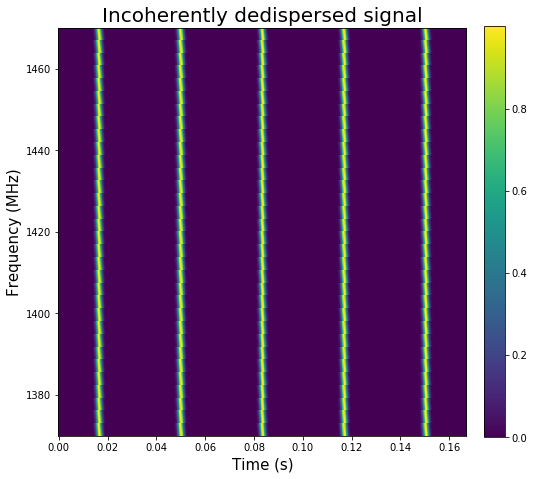

In [6]:
num_channels = 32
channel_width = bandwidth/num_channels

def dedispersed_profile(t, f):
    """Incoherently dedispersed Gaussian profile"""
    channel_num = int((f - f_low)/channel_width)
    channel_freq = f_low + (channel_num + 1/2)*channel_width
    
    channel_delay = delay(channel_freq)

    return profile(t + delay(f) - channel_delay, f)

dedisp = np.vectorize(dedispersed_profile)

t_arr = np.linspace(0, obs_length, 1024)
f_arr = np.linspace(f_low, f_high, 1024)
T, F = np.meshgrid(t_arr, f_arr)
P_dedisp = dedisp(T, F)

# need to scale axes to get correct labels
dt = obs_length/1024
df = bandwidth/1024
extent = [t_arr[0] - dt, t_arr[-1] + dt, f_arr[0] - df, f_arr[-1] + df]

fig, ax = plt.subplots(figsize=(8, 8))

disp = ax.imshow(P_dedisp, extent=extent)
ax.set_aspect(obs_length/bandwidth)

fig.colorbar(disp, fraction=0.046, pad=0.04)

disp.figure.axes[0].tick_params(axis="both", labelsize=10)

plt.xlabel('Time (s)', size=15)
plt.ylabel('Frequency (MHz)', size=15)
plt.title('Incoherently dedispersed signal', size=20)
plt.show()

The smearing is pretty obvious, but most of the dispersion has been removed. Here's what the profile looks like averaged out over all frequencies, along with the difference from the original profile. The improvement is huge! The dedispersed profile is now accurate to within ~1% of the original -- and this was with a relatively low number of channels.

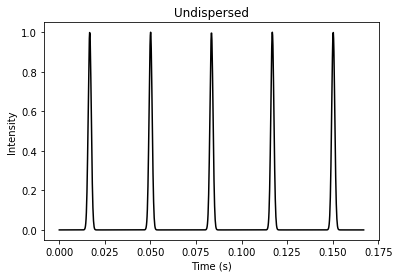

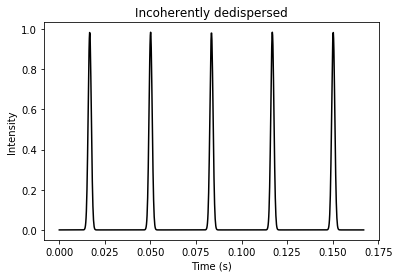

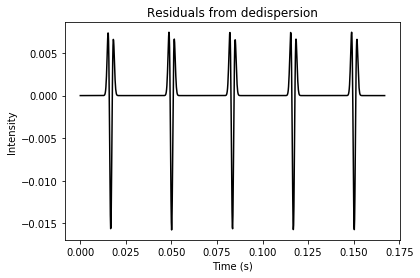

In [7]:
plt.plot(np.linspace(0, obs_length, 1024), sum(P_undisp)/1024, 'k')
plt.xlabel('Time (s)')
plt.ylabel('Intensity')
plt.title('Undispersed')
plt.show()

plt.plot(np.linspace(0, obs_length, 1024), sum(P_dedisp)/1024, 'k')
plt.xlabel('Time (s)')
plt.ylabel('Intensity')
plt.title('Incoherently dedispersed')
plt.show()

plt.plot(np.linspace(0, obs_length, 1024), (sum(P_dedisp) - sum(P_undisp))/1024, 'k')
plt.xlabel('Time (s)')
plt.ylabel('Intensity')
plt.title('Residuals from dedispersion')
plt.show()

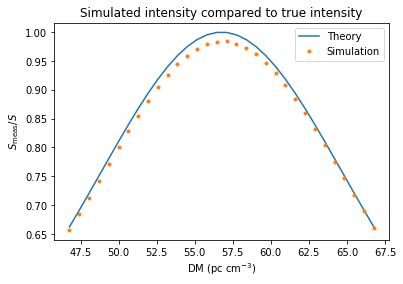

In [8]:
# If the signal is dedispersed at the wrong DM, it will lead to
# a lower calculated flux density than the real flux density.
# For more see Section 3.3.3 of Cordes & McLaughlin 2003
# (https://ui.adsabs.harvard.edu/abs/2003ApJ...596.1142C/abstract).
#
# The below code compares the expected theoretical fluxes
# (eqs. 12, 13) with simulated fluxes.

def dedispersed_profile_wrong_DM(t, f, trial_DM):
    """Incoherently dedispersed Gaussian profile"""
    channel_num = int((f - f_low)/channel_width)
    channel_freq = f_low + (channel_num + 1/2)*channel_width
    
    channel_delay = delay(channel_freq, DM=trial_DM)

    return profile(t + delay(f) - channel_delay, f)

dedisp_wrong = np.vectorize(dedispersed_profile_wrong_DM)

def obs_flux_ratio(trial_DM):
    t_arr = np.linspace(0, obs_length, 1024)
    f_arr = np.linspace(f_low, f_high, 1024)
    T, F = np.meshgrid(t_arr, f_arr)
    P_trial_dedisp = dedisp_wrong(T, F, trial_DM)
    return max(sum(P_trial_dedisp)/1024)

def theoretical_flux_ratio(trial_DM):
    
    delta_DM = trial_DM - crab_DM
    
    W = 2*np.sqrt(2*np.log(2))*(crab_period/40) * 10**3
    scaled_f = 1.420
    
    zeta = 6.91*10**(-3) * delta_DM * bandwidth/(W*(scaled_f**3))
    
    return (np.sqrt(np.pi)/2)*special.erf(zeta)/zeta

trial_DM_range = np.linspace(crab_DM - 10, crab_DM + 10, 32)
obs_list = []
for i in range(len(trial_DM_range)):
    d = trial_DM_range[i]
    obs_list.append(obs_flux_ratio(d))
obs_list = np.array(obs_list)

plt.plot(trial_DM_range, theoretical_flux_ratio(trial_DM_range), label='Theory')
plt.plot(trial_DM_range, obs_list, '.', label='Simulation')
plt.legend()
plt.xlabel('DM (pc cm$^{-3}$)')
plt.ylabel('$S_{\mathrm{meas}}/S$')
plt.title('Simulated intensity compared to true intensity')
plt.show()